In [49]:
import sys
sys.path.append('/opt/conda/pkgs')
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4262b1bf4bf1ffb403c0eb7a42ad5906_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4506eccf78279d93d0e8a34c035e91c5_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/6bda807e3967eae797c7b1b9eeaee8db_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c2a47d89d1d34e789fdf782557bb7194_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c6c5514ada15b890fb27d1e36371554c_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/d964a294c2d0fef56a434c021026281e_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/e1c932db5cd4271709e54d8028824bc9_/lib/python3.12/site-packages")

import pickle, os, gzip, json, sys, itertools
from pathlib import Path
from importlib import reload
from dataclasses import dataclass, field
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pysam
import scipy as sp
import seaborn
import sharedmem


plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 300


sys.path.append("scripts")
sys.path.append("../../scripts")

In [50]:
from data_io import is_fwd_id, get_fwd_id, get_sibling_id
from dim_reduction import SpectralEmbedding, scBiMapEmbedding
from nearest_neighbors import (
    ExactNearestNeighbors,
    NNDescent,
    WeightedLowHash,
    PAFNearestNeighbors,
    LowHash,
    HNSW,
    ProductQuantization,
    _NearestNeighbors,
    IVFProductQuantization,
)
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges
from truth import get_overlaps
from evaluate import NearestNeighborsConfig, mp_compute_nearest_neighbors
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

In [121]:
import glob
evaluate_dir = '/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/Ecoli/all/ONT/kmer_k16/'
file_list = glob.glob(evaluate_dir + '*_overlap_stat.tsv')  
  
# 循环打开文件  
statistic_dfs =[]
for file in file_list:  
    df = pd.read_csv(file, sep='\t') 
    statistic_dfs.append(df)

all_stat_df = pd.concat(statistic_dfs,ignore_index = True)
all_stat_df['connected_fraction'] = 1 - all_stat_df['singleton_fraction']
##筛选用于绘图的method
methods = all_stat_df['description'].unique()
visul_method = []
for method in methods:
    if 'Exact' in method:
        visul_method.append(method)

method_compare = all_stat_df[all_stat_df['description'].isin(visul_method)] 
df = method_compare

visul_method

['ExactNearestNeighbors,Euclidean,None,TF-IDF',
 'ExactNearestNeighbors,Cosine,scBiMapEmbedding,500,TF-IDF',
 'ExactNearestNeighbors,Euclidean,scBiMapEmbedding,500,TF-IDF',
 'Exact_Euclidean_scBiMap_500d_TF-IDF']

In [119]:
methods
visul_method = ['Minimap2', 'WeightedMinHash_Jaccard_None_None',
       'HNSW,Cosine,scBiMapEmbedding,500,None','Exact_Cosine_scBiMap_500d_None', 'MinHash_Jaccard_None_None',
       'PQ_Cosine_scBiMap_500d_None']
method_compare = all_stat_df[all_stat_df['description'].isin(visul_method)] 
df = method_compare


In [122]:
methods

array(['HNSW,Euclidean,scBiMapEmbedding,500,TF',
       'HNSW,Cosine,scBiMapEmbedding,500,TF-IDF', 'Minimap2 all-vs-all',
       'ExactNearestNeighbors,Euclidean,None,TF-IDF',
       'ExactNearestNeighbors,Cosine,scBiMapEmbedding,500,TF-IDF',
       'ProductQuantization,Cosine,scBiMapEmbedding,500,TF',
       'ProductQuantization,Euclidean,scBiMapEmbedding,500,TF-IDF',
       'LowHash,Jaccard,None,TF-IDF',
       'HNSW,Cosine,scBiMapEmbedding,500,None',
       'ExactNearestNeighbors,Euclidean,scBiMapEmbedding,500,TF-IDF',
       'ProductQuantization,Euclidean,scBiMapEmbedding,500,None',
       'NNDescent,Euclidean,scBiMapEmbedding,500,TF-IDF',
       'Exact_Euclidean_scBiMap_500d_TF-IDF',
       'MinHash,Jaccard,None,TF-IDF',
       'ProductQuantization,Euclidean,scBiMapEmbedding,500,TF',
       'HNSW,Cosine,scBiMapEmbedding,500,TF',
       'WeightedMinHash_Jaccard_None_TF-IDF',
       'HNSW,Euclidean,scBiMapEmbedding,500,IDF',
       'HNSW,Euclidean,scBiMapEmbedding,500,None', 'Blend'

In [91]:
df[df.description=='MinHash,Jaccard,None,None']

,description,n_neighbors,precision,nr_precision,recall,nr_recall,singleton_count,singleton_fraction,N50,elapsed_time:dimension_reduction,elapsed_time:nearest_neighbors,connected_fraction,elapsed_time:tfidf,N50_percentage
703,"MinHash,Jaccard,None,None",2,0.751832,0.143733,0.054655,0.109365,1387,0.271641,60,NaN,162.024569,0.728359,NaN,NaN
704,"MinHash,Jaccard,None,None",3,0.748500,0.137240,0.078535,0.150720,833,0.163141,327,NaN,162.024569,0.836859,NaN,NaN
705,"MinHash,Jaccard,None,None",4,0.744501,0.131416,0.101272,0.187107,515,0.100862,813,NaN,162.024569,0.899138,NaN,NaN
706,"MinHash,Jaccard,None,None",5,0.739219,0.125145,0.123497,0.218832,317,0.062084,1251,NaN,162.024569,0.937916,NaN,NaN
707,"MinHash,Jaccard,None,None",6,0.734478,0.120942,0.145024,0.249949,202,0.039561,1257,NaN,162.024569,0.960439,NaN,NaN
708,"MinHash,Jaccard,None,None",7,0.731398,0.115880,0.166676,0.276404,136,0.026635,1261,NaN,162.024569,0.973365,NaN,NaN
709,"MinHash,Jaccard,None,None",8,0.726860,0.110961,0.187448,0.299513,93,0.018214,1285,NaN,162.024569,0.981786,NaN,NaN
710,"MinHash,Jaccard,None,None",9,0.722703,0.107471,0.207861,0.323535,67,0.013122,2547,NaN,162.024569,0.986878,NaN,NaN
711,"MinHash,Jaccard,None,None",10,0.718711,0.105220,0.227606,0.348774,45,0.008813,2549,NaN,162.024569,0.991187,NaN,NaN
712,"MinHash,Jaccard,None,None",11,0.715891,0.102829,0.247962,0.372795,27,0.005288,2551,NaN,162.024569,0.994712,NaN,NaN


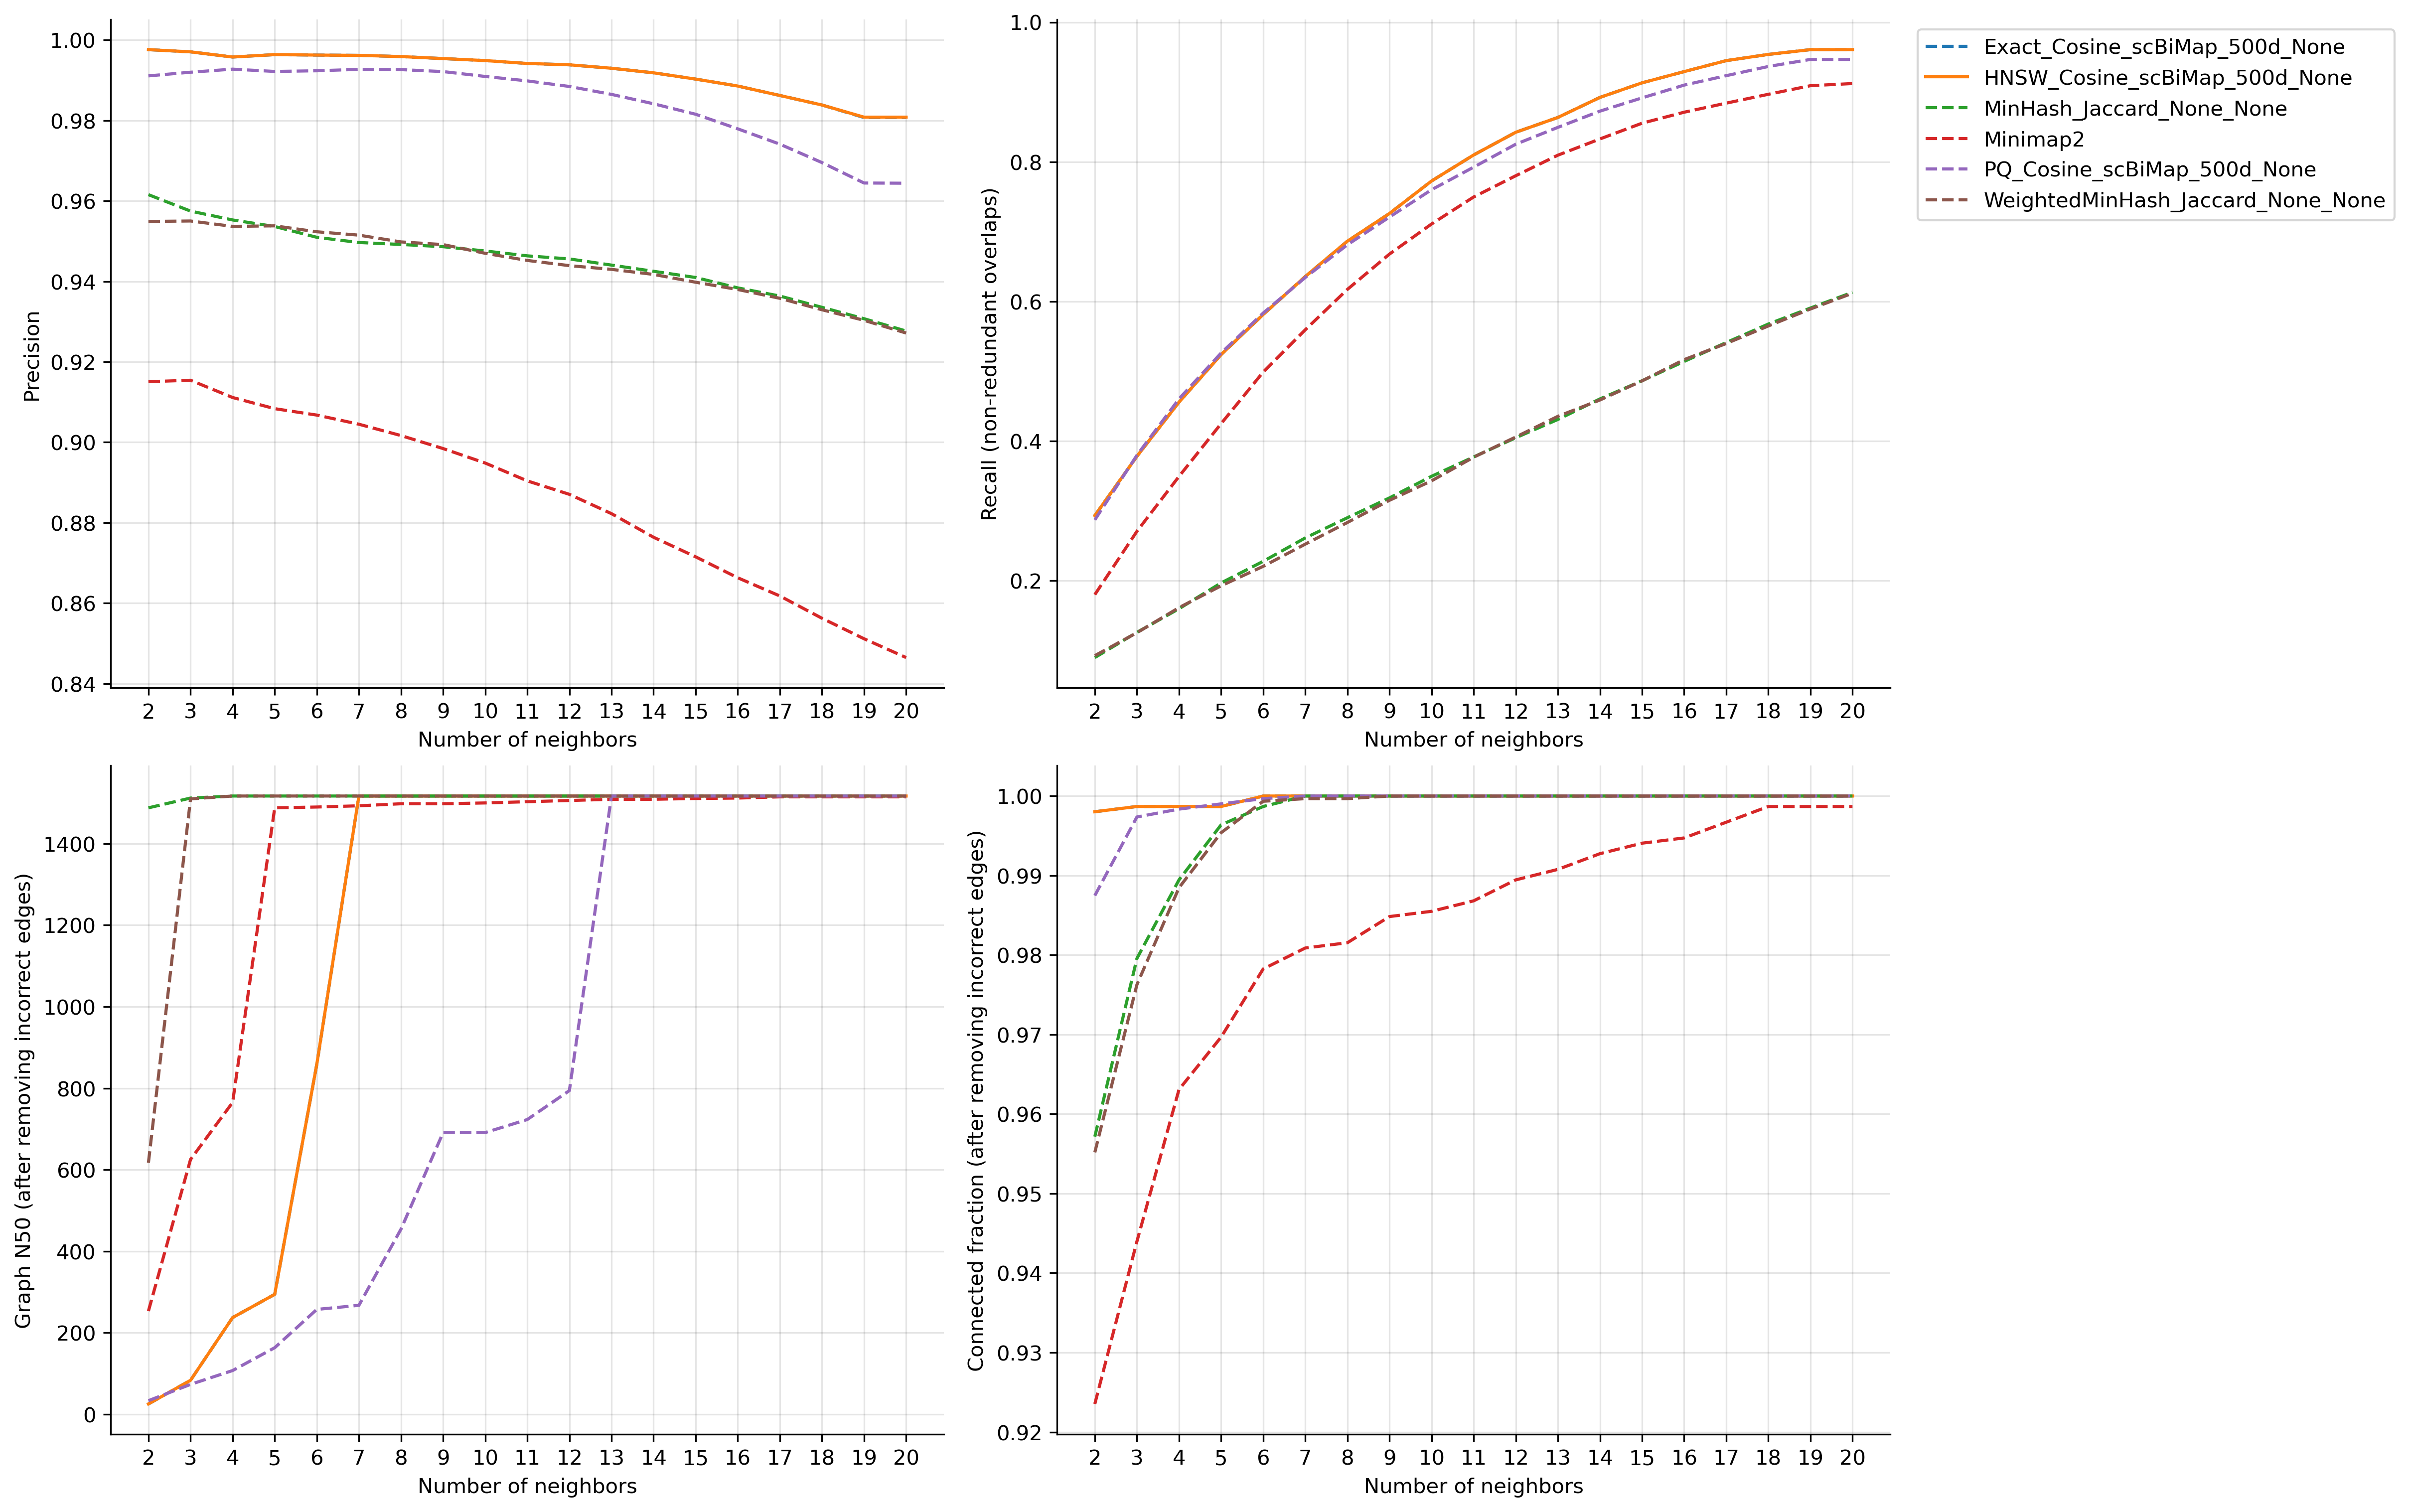

In [120]:
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df.groupby(hue)): 
        if 'HNSW' in desc:  
            linestyle = 'solid'  
        elif '--' in desc: 
            linestyle = 'dotted'
        else:
            linestyle = 'dashed'
        ax.plot(group[x], group[y], label=desc, color = color_list[j],linestyle = linestyle)
    ax.set_xticks(k_values) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

In [55]:
import glob
evaluate_dir = '/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/Ecoli/all/ONT/kmer_k16/'
file_list = glob.glob(evaluate_dir + '*_overlap_stat.tsv')  
  
# 循环打开文件  
statistic_dfs =[]
for file in file_list:  
    df = pd.read_csv(file, sep='\t') 
    statistic_dfs.append(df)

all_stat_df = pd.concat(statistic_dfs,ignore_index = True)
all_stat_df = all_stat_df.iloc[:,2:]
all_stat_df['connected_fraction'] = 1 - all_stat_df['singleton_fraction']
##筛选用于绘图的method
methods = all_stat_df['description'].unique()
visul_method = []
for method in methods:
    if  'TF-IDF' in method or 'Blend' in method or 'Mini' in method:
        visul_method.append(method)

method_compare = all_stat_df[all_stat_df['description'].isin(visul_method)] 
df2 = method_compare

visul_method

['HNSW,Cosine,scBiMapEmbedding,500,TF-IDF',
 'Minimap2 all-vs-all',
 'ExactNearestNeighbors,Euclidean,None,TF-IDF',
 'ExactNearestNeighbors,Cosine,scBiMapEmbedding,500,TF-IDF',
 'ProductQuantization,Euclidean,scBiMapEmbedding,500,TF-IDF',
 'LowHash,Jaccard,None,TF-IDF',
 'ExactNearestNeighbors,Euclidean,scBiMapEmbedding,500,TF-IDF',
 'NNDescent,Euclidean,scBiMapEmbedding,500,TF-IDF',
 'Exact_Euclidean_scBiMap_500d_TF-IDF',
 'MinHash,Jaccard,None,TF-IDF',
 'WeightedMinHash_Jaccard_None_TF-IDF',
 'Blend',
 'HNSW,Euclidean,scBiMapEmbedding,500,TF-IDF',
 'HNSW_Euclidean_scBiMap_500d_TF-IDF',
 'ProductQuantization,Cosine,scBiMapEmbedding,500,TF-IDF',
 'WeightedMinHash,Jaccard,None,TF-IDF',
 'NNDescent_Euclidean_scBiMap_500d_TF-IDF']

In [56]:
time_df = df2[df2['n_neighbors']==20]
time_df.to_csv('/home/miaocj/docker_dir/kNN-overlap-finder/time_df.csv',sep='\t')

In [57]:
time_df

,description,n_neighbors,precision,nr_precision,recall,nr_recall,singleton_count,singleton_fraction,N50,elapsed_time:dimension_reduction,elapsed_time:nearest_neighbors,connected_fraction,elapsed_time:tfidf
37,"HNSW,Cosine,scBiMapEmbedding,500,TF-IDF",20,0.802599,0.074724,0.117236,0.460881,1463,0.020791,8729,588.380615,1.477817,0.979209,0.702651
56,Minimap2 all-vs-all,20,0.866124,0.032032,0.201774,0.315098,2280,0.032491,24688,NaN,28.682720,0.967509,NaN
75,"ExactNearestNeighbors,Euclidean,None,TF-IDF",20,0.915099,0.097083,0.147983,0.662911,944,0.013415,25163,NaN,148.710929,0.986585,1.452542
94,"ExactNearestNeighbors,Cosine,scBiMapEmbedding,...",20,0.833727,0.077821,0.118935,0.468759,1304,0.018531,8721,621.804743,180.844221,0.981469,0.758613
132,"ProductQuantization,Euclidean,scBiMapEmbedding...",20,0.741578,0.059466,0.124065,0.420081,1989,0.028266,2695,1401.477157,45.700873,0.971734,1.051698
151,"LowHash,Jaccard,None,TF-IDF",20,0.893654,0.072453,0.173915,0.595382,849,0.012067,25278,NaN,829.648621,0.987933,0.698908
189,"ExactNearestNeighbors,Euclidean,scBiMapEmbeddi...",20,0.833727,0.077821,0.118935,0.468759,1304,0.018531,8721,588.365537,137.982407,0.981469,0.690536
227,"NNDescent,Euclidean,scBiMapEmbedding,500,TF-IDF",20,0.833754,0.077820,0.118945,0.468781,1309,0.018602,8722,594.758464,32.550925,0.981398,0.713388
246,Exact_Euclidean_scBiMap_500d_TF-IDF,20,0.833727,0.077821,0.118935,0.468759,1304,0.018531,8721,722.830584,140.604465,0.981469,0.702580
265,"MinHash,Jaccard,None,TF-IDF",20,0.882233,0.069014,0.147078,0.485813,780,0.011100,25274,NaN,1077.105308,0.988900,0.715246


In [58]:
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df2.groupby(hue)): 
        if 'HNSW' in desc:  
            linestyle = 'dashed'  
        elif 'Hash' in desc: 
            linestyle = 'dotted'
        else:
            linestyle = 'solid'
        ax.plot(group[x], group[y], label=desc, color = color_list[j],linestyle = linestyle)
    ax.set_xticks(k_values) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

Error in callback <function flush_figures at 0x7f45ee7cd120> (for post_execute):


KeyboardInterrupt: 

In [ ]:
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df.groupby(hue)): 
        if 'Pro' in desc:  
            linestyle = 'dashed'  
        elif 'Jaccard' in desc: 
            linestyle = 'dotted'
        else:
            linestyle = 'solid'
        ax.plot(group[x], group[y], label=desc, color = color_list[j],linestyle = linestyle)
    ax.set_xticks(k_values) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

## 绘制plot_graph

In [ ]:
def remove_small_components(graph, min_component_size=10):
    small_components = set()
    for component in nx.connected_components(graph):
        if len(component) < min_component_size:
            small_components |= component
    graph.remove_nodes_from(small_components)
            
    
def plot_graphs(graphs, reference_graph, metadata, *, min_component_size=10, 
                processes=8, layout_method='stdp', figsize=(6, 6), node_size=3,title,
    seed: int = 4829, verbose=True):
    axes = []
    figures = []

    new_graphs = []
    for g in graphs:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
        figures.append(fig)
        ax1.set_title("All edges")
        ax2.set_title("Correct edges")
        
        g = g.copy()
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax1)

        g = g.copy()
        remove_false_edges(g, reference_graph)
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax2)
        fig.suptitle(title, ha="center", va="bottom", wrap=True, size=7)

    query_graphs = new_graphs
    def plot(i, pos):
        plot_read_graph(
            ax=axes[i],
            query_graph=query_graphs[i],
            reference_graph=reference_graph,
            metadata=metadata,
            pos=pos,
            node_size=node_size,
        )

    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            if layout_method == "umap":
                pos = get_umap_layout(graph=query_graphs[i])
            else:
                pos = get_graphviz_layout(
                    graph=query_graphs[i],
                    figsize=figsize,
                    seed=seed,
                    layout_method=layout_method,
                )
            return i, pos

        def reduce(i, pos):
            if verbose:
                print(i, end=" ")
            plot(i, pos)

        pool.map(work, range(len(query_graphs)), reduce=reduce)
        if verbose:
            print("")

    return figures

In [ ]:
MAX_SAMPLE_SIZE = int(1e9)
COVERAGE_DEPTH = 20
max_bucket_size = COVERAGE_DEPTH * 1.5

tsv_path = "/home/miaochangjiu/kNN-overlap-finder/data/feature_matrix/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/metadata.tsv.gz"
meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()

def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)
len(read_intervals)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

(7448, 150966, 14394, 2)

In [ ]:
max_n_neighbors = 20
json_path = "/home/miaochangjiu/kNN-overlap-finder/data/feature_matrix/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/read_features.json.gz"
with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}
    
read_ids = np.array(list(read_features))
graphs = collections.defaultdict(dict)
k_values = np.arange(2, max_n_neighbors + 1)
datas = np.load('/home/miaochangjiu/kNN-overlap-finder/data/evaluation/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/WeightedMinHash_Jaccard_None_TF_nbr_matrix.npz',allow_pickle=True)
nbr_indices = datas['arr_0'].item()[0]
for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graphs[0][k] = graph

In [ ]:
nbr_indices.item()[0]

array([[6175, 3019, 4512, ...,   20,  968, 2633],
       [6114, 4513, 3018, ..., 2343, 3071,  969],
       [4285, 6949, 7054, ..., 2829, 5981, 4993],
       ...,
       [2322, 4029, 7069, ..., 5129, 2942, 3438],
       [6629,  402, 1121, ..., 4705, 7030, 2950],
       [2272, 3743, 4064, ..., 6588, 4704, 6507]])

1 0 


[<Figure size 3600x1800 with 2 Axes>]

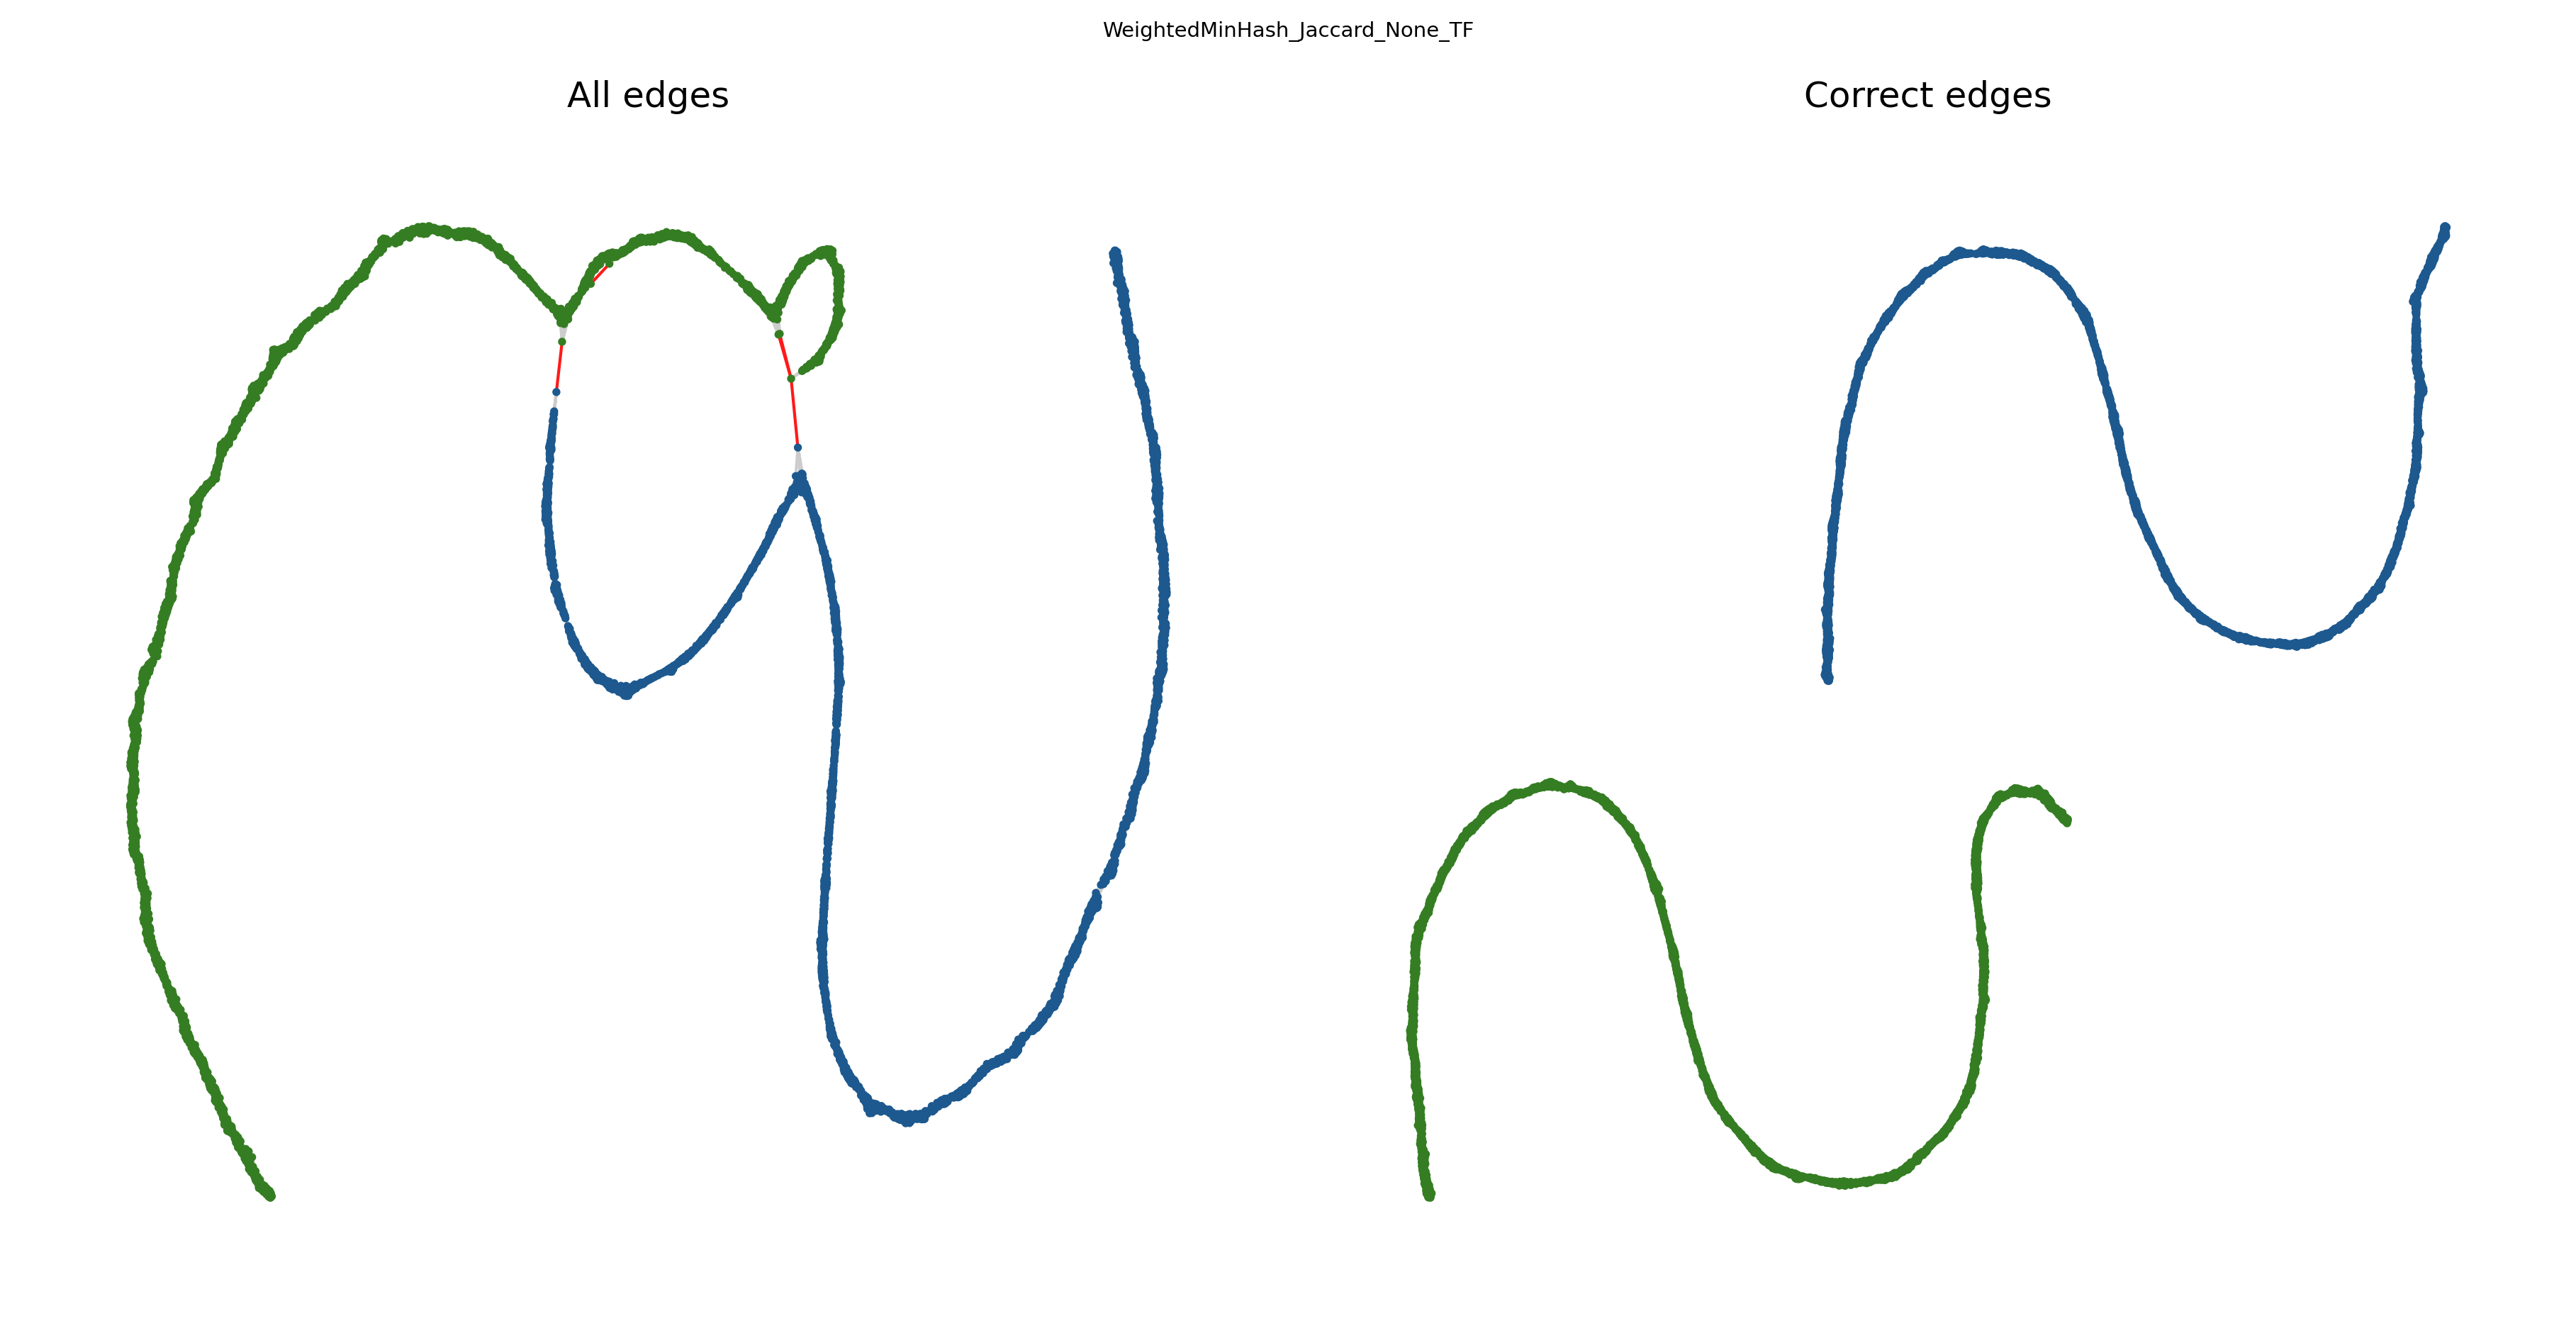

In [ ]:
%%time
k6_graphs = [graphs[0][6] for i in range(len(graphs))]
plot_graphs(
    k6_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=8,title= 'WeightedMinHash_Jaccard_None_TF'
)